In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity: ROI-wise.

In [2]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:2") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 4
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.10.0+cu113
cuda:  11.3
cudnn: 8200
dtype: torch.float32


In [4]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'gnet8r_mpf_evc'
model_dir = '%s_%s' % (model_name, timestamp)

output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 

trn_subjects = [1,2,3,4,5,6,7,8]
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: Feb-05-2022_2105


# Load the stimuli images
From the subjectwise image preparation

In [5]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 2  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 3  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 4  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 5  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 6  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 7  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 8  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


## Examples

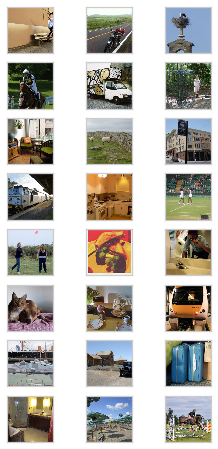

In [6]:
n = 1003
plt.figure(figsize=(4,1*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [7]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [8]:
beta_dir = '/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/'

In [9]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    #voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ncsnr_full = load_mask_from_nii(beta_dir + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
        
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 4627
1348 	: V1
1415 	: V2
1188 	: V3
676 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 2  -------
(82, 106, 84)
full mask length = 730128
selection length = 3765
1097 	: V1
1083 	: V2
1081 	: V3
504 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 3  -------
(81, 106, 82)
full mask length = 704052
selection length = 3778
1251 	: V1
1160 	: V2
945 	: V3
422 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 4  -------
(85, 99, 80)
full mask length = 673200
selection length = 3027
871 	: V1
883 	: V2
800 	: V3
473 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 5  -------
(79, 97, 78)
full mask length = 597714
selection length = 3685
1115 	: V1
1088 	: V2
934 	: V3
548 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO

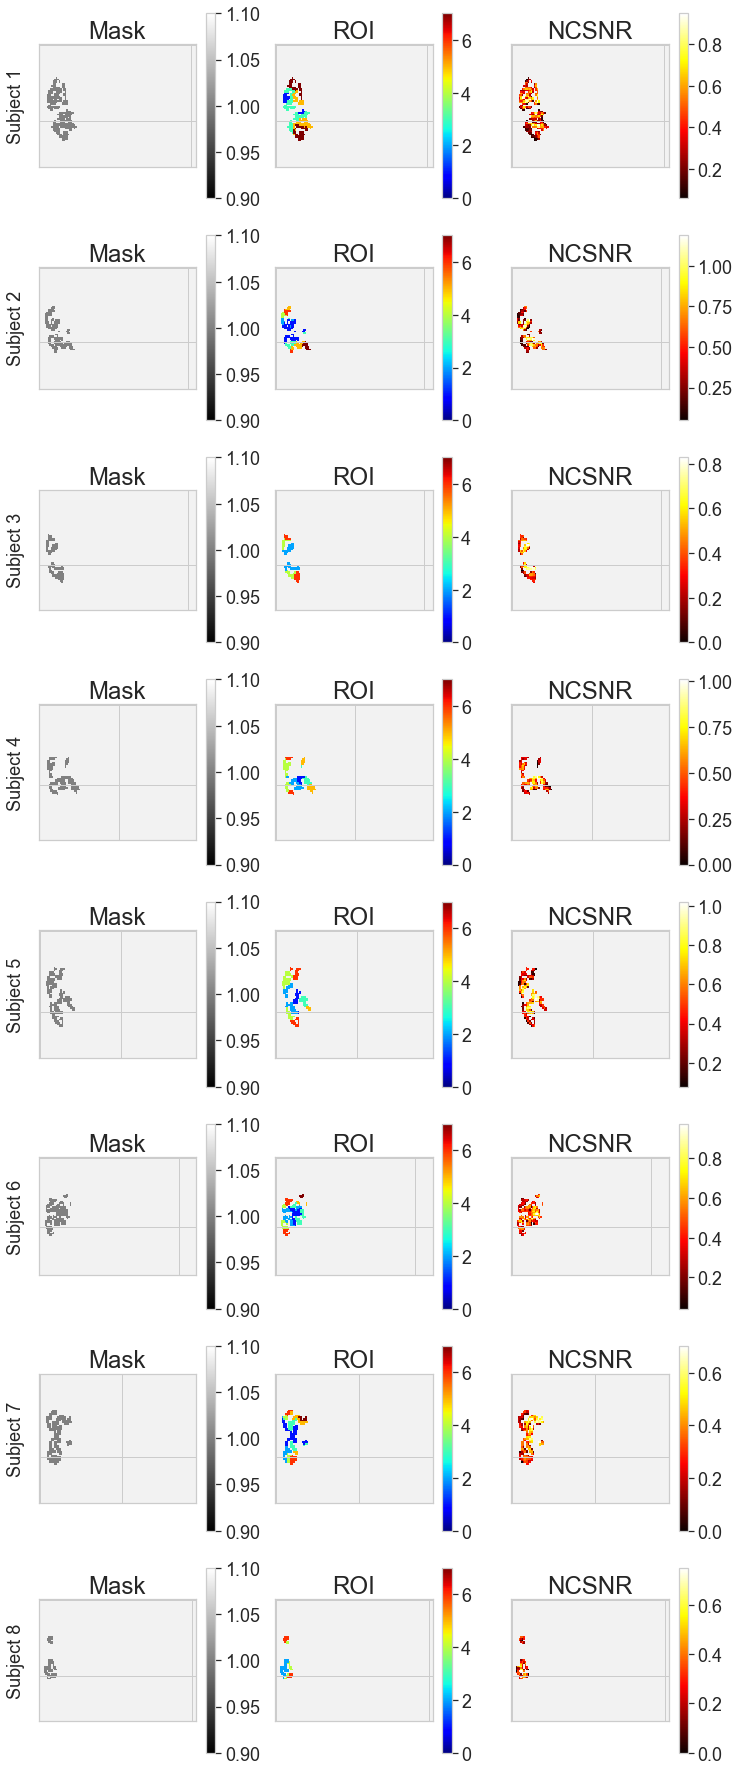

In [10]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    volume_ncsnr      = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+3)
    plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
    plt.title('NCSNR')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])

# Create the batched voxel masks 

In [11]:
block_group_names = ['V1', 'V2', 'V3', 'hV4'] #['V1', 'V2', 'V3', 'hV4-LO', 'IPS', 'other']
block_group = [[1,2], [3,4], [5,6], [7]] # [[1,2], [3,4], [5,6], [7,14,15], [18,19,20,21,22,23], [8,9,10,11,12,13,16,17,24,25,0]]

In [12]:
block_voxel_masks = {}
for roi_name in block_group_names:
    block_voxel_masks[roi_name] = {}

for s in trn_subjects:
    for roi_mask, roi_name in iterate_roi(block_group, voxel_roi[s], roi_map, group_name=block_group_names):    
        block_voxel_masks[roi_name][s] = roi_mask

print (['%s: %d'%(s,np.sum(v)) for s,v in flatten_dict(block_voxel_masks).items()])

['V1.1: 1348', 'V1.2: 1097', 'V1.3: 1251', 'V1.4: 871', 'V1.5: 1115', 'V1.6: 1130', 'V1.7: 1148', 'V1.8: 1081', 'V2.1: 1415', 'V2.2: 1083', 'V2.3: 1160', 'V2.4: 883', 'V2.5: 1088', 'V2.6: 1191', 'V2.7: 958', 'V2.8: 1040', 'V3.1: 1188', 'V3.2: 1081', 'V3.3: 945', 'V3.4: 800', 'V3.5: 934', 'V3.6: 1215', 'V3.7: 721', 'V3.8: 879', 'hV4.1: 676', 'hV4.2: 504', 'hV4.3: 422', 'hV4.4: 473', 'hV4.5: 548', 'hV4.6: 488', 'hV4.7: 374', 'hV4.8: 490']


# Load voxels
Only run one of these cells
## Quick load (Load the voxel data block for these voxels only)

In [13]:
#voxel_data_set = h5py.File(root_dir+'voxel_synth_data_V1-4_part1.h5py', 'r')
#voxel_data_set = h5py.File(voxel_dir+'voxel_data_nsdgeneral_part1.h5py', 'r')
voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part1.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = voxel_data_dict['voxel_data']

#voxel_data_set = h5py.File(root_dir+'voxel_synth_data_V1-4_part2.h5py', 'r')
#voxel_data_set = h5py.File(voxel_dir+'voxel_data_nsdgeneral_part2.h5py', 'r')
voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part2.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data.update(voxel_data_dict['voxel_data'])

voxel_data = {s: voxel_data['%d'%s] for s in voxel_roi.keys()}
print (voxel_data.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])


## Slow load from raw data

In [25]:
***
## Long version
from src.load_nsd import load_betas

voxel_data = {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/"%s
    voxel_data[s],_ = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask[s], up_to=-1)
    print ('----------------------------')
    print (voxel_data[s].shape)
    
save_stuff(root_dir + 'voxel_data_general_part2', 
    flatten_dict({
   'voxel_mask': voxel_mask,
   'voxel_roi': voxel_roi,
   'voxel_idx': voxel_idx,
   'voxel_ncsnr': voxel_ncsnr,
   'voxel_data': voxel_data
            }))

--------  subject 3  -------
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
int16 -32768 32767 (750, 82, 106, 81)
<beta> = 1.063, <sigma> = 0.973
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
int16 -32768 32767 (750, 82, 106, 81)
<beta> = 1.081, <sigma> = 1.059
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
int16 -32768 32767 (750, 82, 106, 81)
<beta> = 1.186, <sigma> = 1.047
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 82, 106, 81)
<beta> = 1.058, <sigma> = 0.908
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
int16 -32768 32767 (750, 82, 106, 81)
<beta> = 1.003, <sigma> = 0.873
/home/

int16 -32768 32767 (750, 80, 99, 85)
<beta> = 1.073, <sigma> = 0.873
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session12.mat
int16 -32768 32767 (750, 80, 99, 85)
<beta> = 0.976, <sigma> = 0.857
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session13.mat
int16 -32768 32767 (750, 80, 99, 85)
<beta> = 1.179, <sigma> = 0.964
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session14.mat
int16 -32768 32767 (750, 80, 99, 85)
<beta> = 0.896, <sigma> = 0.801
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session15.mat
int16 -32768 32767 (750, 80, 99, 85)
<beta> = 0.940, <sigma> = 0.863
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session16.mat
int16 -32768 32767 (750, 80, 99, 85)
<be

int16 -32768 32767 (750, 81, 95, 78)
<beta> = 0.772, <sigma> = 0.822
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session25.mat
int16 -32768 32767 (750, 81, 95, 78)
<beta> = 1.151, <sigma> = 1.094
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session26.mat
int16 -32768 32767 (750, 81, 95, 78)
<beta> = 0.764, <sigma> = 0.925
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session27.mat
int16 -32768 32767 (750, 81, 95, 78)
<beta> = 0.936, <sigma> = 0.940
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session28.mat
int16 -32768 32767 (750, 81, 95, 78)
<beta> = 0.846, <sigma> = 0.975
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session29.mat
int16 -32768 32767 (750, 81, 95, 78)
<be

<beta> = 0.679, <sigma> = 0.846
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session27.mat
int16 -32768 32767 (750, 78, 103, 80)
<beta> = 1.159, <sigma> = 1.008
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session28.mat
int16 -32768 32767 (750, 78, 103, 80)
<beta> = 1.081, <sigma> = 1.039
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session29.mat
int16 -32768 32767 (750, 78, 103, 80)
<beta> = 0.950, <sigma> = 0.942
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session30.mat
int16 -32768 32767 (750, 78, 103, 80)
<beta> = 0.675, <sigma> = 0.798
----------------------------
(22500, 10178)
saved voxel_mask.1 in h5py file
saved voxel_mask.2 in h5py file
saved voxel_mask.3 in h5py file
saved voxel_mask.4 in h5py file
saved voxel_mask.5 in h5

# Dataset split and unpacking or averaging
## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.

In [14]:
from src.load_nsd import image_feature_fn, ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

stim_data = {}
data_size, nnv = {}, {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape      
    stim_data[s] = image_feature_fn(image_data[s])
    
    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)
    
del image_data
del voxel_data

--------  subject 1  -------
Total number of voxels = 4627
--------  subject 2  -------
Total number of voxels = 3765
--------  subject 3  -------
Total number of voxels = 3778
--------  subject 4  -------
Total number of voxels = 3027
--------  subject 5  -------
Total number of voxels = 3685
--------  subject 6  -------
Total number of voxels = 4024
--------  subject 7  -------
Total number of voxels = 3201
--------  subject 8  -------
Total number of voxels = 3490


In [15]:
trn_stim_mean = sum([np.mean(stim_data[s][1000:], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.4751836 ]]

  [[0.4515587 ]]

  [[0.41180962]]]]


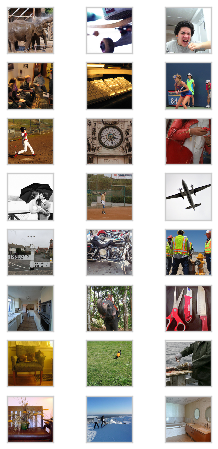

In [16]:
n = 1006
plt.figure(figsize=(4,1*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(stim_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

---
# Model

In [17]:
from src.torch_joint_training_unpacked_sequences import *
from src.torch_gnet import Encoder
from src.torch_mpf import Torch_LayerwiseFWRF

## Model instanciation

In [18]:
_log_act_fn = lambda _x: T.log(1 + T.abs(_x))*T.tanh(_x)

In [19]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _smoothness_loss_fn(_rf, n):
    delta_x = T.sum(T.pow(T.abs(_rf[:, 1:]    - _rf[:, :-1]), n))
    delta_y = T.sum(T.pow(T.abs(_rf[:, :, 1:] - _rf[:, :, :-1]), n))
    return delta_x + delta_y

def vox_loss_fn(r, v, nu=0.5, delta=1.):
    #err = T.sum(huber(r, v, delta), dim=0)
    err = T.sum((r - v)**2, dim=0)
    # squared correlation coefficient with 'leak'
    cr = r - T.mean(r, dim=0, keepdim=True)
    cv = v - T.mean(v, dim=0, keepdim=True)
    wgt = T.clamp(T.pow(T.mean(cr*cv, dim=0), 2) / ((T.mean(cr**2, dim=0)) * (T.mean(cv**2, dim=0)) + 1e-6), min=nu, max=1).detach()
 
    weighted_err = wgt * err # error per voxel
    loss = T.sum(weighted_err) / T.mean(wgt)
    return err, loss
    
def _loss_fn(_ext, _con, _x, _v):
    _r = _model_fn(_ext, _con, _x)
    #_err = T.sum((_r - _v)**2, dim=0)
    #_loss = T.sum(_err)
    _err, _loss = vox_loss_fn(_r, _v, nu=0.1, delta=.5)

    _loss += fpX(1e-1) * T.sum(T.abs(_con.w))
    return _err, _loss
    
def _training_fn(_ext, _con, _opts, xb, yb):
    for _opt in _opts:
        _opt.zero_grad()
        _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
        _loss.backward()
        _opt.step()
    return _err

def _holdout_fn(_ext, _con, xb, yb):
    # print (xb.shape, yb.shape)
    _err,_ = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    return _err

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

def print_grads(_ext, _con, _params, _opt, xb, yb):
    _opt.zero_grad()
    _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))  
    _loss.backward()   
    for p in _params:
        prg = get_value(p.grad)     
        print ("%-16s : value=%f, grad=%f" % (list(p.size()), np.mean(np.abs(get_value(p))), np.mean(np.abs(prg))))
    print ('--------------------------------------')
    sys.stdout.flush()

In [20]:
N = 64
roi_nv = {s: np.sum(roi_mask) for s, roi_mask in block_voxel_masks['V1'].items()}
    
shared_model = Encoder(trn_stim_mean, trunk_width=N).to(device)
rec, fmaps, h = shared_model(T.from_numpy(stim_data[trn_subjects[0]][:20]).to(device))

subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=roi_nv[1], pre_nl=_log_act_fn, \
                     post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}   

In [21]:
for s,sp in subject_fwrfs.items():
    print ("--------- subject %d ----------"%s)
    for p in sp.parameters():
        print ("block size %-16s" % (list(p.size())))
        
param_count = 0
for w in shared_model.enc.parameters():
    param_count += np.prod(tuple(w.size()))
print ('')
print (param_count, "shared params")
total_nv = 0
for s,sp in subject_fwrfs.items():
    for p in sp.parameters():
        param_count += np.prod(tuple(p.size()))
    total_nv += roi_nv[s]
print (param_count // total_nv, "approx params per voxels")

--------- subject 1 ----------
block size [1348, 25, 25]  
block size [1348, 13, 13]  
block size [1348, 512]     
block size [1348]          
--------- subject 2 ----------
block size [1348, 25, 25]  
block size [1348, 13, 13]  
block size [1348, 512]     
block size [1348]          
--------- subject 3 ----------
block size [1348, 25, 25]  
block size [1348, 13, 13]  
block size [1348, 512]     
block size [1348]          
--------- subject 4 ----------
block size [1348, 25, 25]  
block size [1348, 13, 13]  
block size [1348, 512]     
block size [1348]          
--------- subject 5 ----------
block size [1348, 25, 25]  
block size [1348, 13, 13]  
block size [1348, 512]     
block size [1348]          
--------- subject 6 ----------
block size [1348, 25, 25]  
block size [1348, 13, 13]  
block size [1348, 512]     
block size [1348]          
--------- subject 7 ----------
block size [1348, 25, 25]  
block size [1348, 13, 13]  
block size [1348, 512]     
block size [1348]          

# Training

In [ ]:
batch_size = 100
num_epochs = 50
holdout_frac = .1
 
for roi_name, roi_masks in block_voxel_masks.items(): 
    
    roi_nv = {s: np.sum(roi_mask) for s, roi_mask in roi_masks.items()}
    
    print ('***************************************')
    print ('***        %12s       ***'%roi_name)
    print ({s: np.sum(m) for s,m in roi_masks.items()})
    print ('***************************************') 
    
    # create model
    shared_model = Encoder(trn_stim_mean, trunk_width=N).to(device)
    rec, fmaps, h = shared_model(T.from_numpy(stim_data[trn_subjects[0]][:20]).to(device))

    subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=roi_nv[s], pre_nl=_log_act_fn, \
                     post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}    
    
    ##################################
    try:
        from torch.hub import load_state_dict_from_url
    except ImportError:
        from torch.utils.model_zoo import load_url as load_state_dict_from_url

    state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
            ### Rename dictionary keys to match new breakdown
    pre_state_dict = {}
    pre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')
    pre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')
    pre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')
    pre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')

    shared_model.pre.load_state_dict(pre_state_dict)
    ###################################
    optimizer_net = optim.Adam([
            #{'params': shared_model.pre.parameters()},
            {'params': shared_model.enc.parameters()},
        ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)
    subject_optimizer = {s: optim.Adam([
            {'params': sp.parameters()}
        ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}
    subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}   
    ###################################
    best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
        learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
            stim_data, trn_voxel_data, trn_stim_ordering,
            num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, masks=roi_masks, randomize=False)
    
    ###################################
    #val_voxel = {s: val_voxel_data[s] for s in val_voxel_data.keys()}
    shared_model.load_state_dict(best_params['enc'])
    shared_model.eval() 
    for s,sd in subject_fwrfs.items():
        sd.load_state_dict(best_params['fwrfs'][s])
        sd.eval() 

    subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, stim_data, val_voxel_data, val_stim_ordering, batch_size, masks=roi_masks)
    joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)
    
    print ('***************************************')
    print ("best joint val cc = %.3f"% np.median(joined_val_cc))
    for s,v in subject_val_cc.items():
        print ("subject %s: val cc = %.3f"%(s, np.median(v)))
 
    print ('***************************************')
    ###################################
    torch.save({
            'group_name': roi_name,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_frac': holdout_frac,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'input_mean': trn_stim_mean,
            'brain_nii_shape': brain_nii_shape,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask,
            'group_mask': roi_masks
            }, output_dir+'model_params_%s'%roi_name)

***************************************
***                  V1       ***
{1: 1348, 2: 1097, 3: 1251, 4: 871, 5: 1115, 6: 1130, 7: 1148, 8: 1081}
***************************************
subject 1 masked 1348 of 4627
subject 1 training/holdout 24300 2700
subject 2 masked 1097 of 3765
subject 2 training/holdout 24300 2700
subject 3 masked 1251 of 3778
subject 3 training/holdout 19466 2163
subject 4 masked 871 of 3027
subject 4 training/holdout 18280 2032
subject 5 masked 1115 of 3685
subject 5 training/holdout 24300 2700
subject 6 masked 1130 of 4024
subject 6 training/holdout 19466 2163
subject 7 masked 1148 of 3201
subject 7 training/holdout 24300 2700
subject 8 masked 1081 of 3490
subject 8 training/holdout 18280 2032
/ : 0.1 %

/export/raid1/home/styvesg/code/nsd_gnet8x/src/torch_joint_training_unpacked_sequences.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  islices = np.array(islices)[ordering]


/ : 3.1 % %

/export/raid1/home/styvesg/code/nsd_gnet8x/src/torch_joint_training_unpacked_sequences.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  islices = np.array(islices)#, dtype=int)


/ : 100.0 %
  Epoch 1 of 50 took       124.734s
  training loss:               0.953606
  holdout loss (batch):        0.942766
  Subject 1: median (max) validation accuracy = 0.211 (0.587)
  Subject 2: median (max) validation accuracy = 0.245 (0.566)
  Subject 3: median (max) validation accuracy = 0.228 (0.439)
  Subject 4: median (max) validation accuracy = 0.220 (0.604)
  Subject 5: median (max) validation accuracy = 0.265 (0.515)
  Subject 6: median (max) validation accuracy = 0.236 (0.649)
  Subject 7: median (max) validation accuracy = 0.138 (0.472)
  Subject 8: median (max) validation accuracy = 0.152 (0.502)
** Saving params with joint score = 0.209 **

/ : 100.0 %
  Epoch 2 of 50 took       124.829s
  training loss:               0.932516
  holdout loss (batch):        0.930643
  Subject 1: median (max) validation accuracy = 0.253 (0.652)
  Subject 2: median (max) validation accuracy = 0.288 (0.639)
  Subject 3: median (max) validation accuracy = 0.247 (0.461)
  Subject 4: med

  Subject 2: median (max) validation accuracy = 0.423 (0.733)
  Subject 3: median (max) validation accuracy = 0.290 (0.525)
  Subject 4: median (max) validation accuracy = 0.296 (0.666)
  Subject 5: median (max) validation accuracy = 0.305 (0.550)
  Subject 6: median (max) validation accuracy = 0.339 (0.682)
  Subject 7: median (max) validation accuracy = 0.173 (0.499)
  Subject 8: median (max) validation accuracy = 0.185 (0.520)
** Saving params with joint score = 0.294 **

/ : 100.0 %
  Epoch 14 of 50 took       125.204s
  training loss:               0.873767
  holdout loss (batch):        0.893721
  Subject 1: median (max) validation accuracy = 0.415 (0.737)
  Subject 2: median (max) validation accuracy = 0.426 (0.735)
  Subject 3: median (max) validation accuracy = 0.289 (0.523)
  Subject 4: median (max) validation accuracy = 0.295 (0.670)
  Subject 5: median (max) validation accuracy = 0.305 (0.550)
  Subject 6: median (max) validation accuracy = 0.341 (0.682)
  Subject 7: median

  Subject 7: median (max) validation accuracy = 0.174 (0.501)
  Subject 8: median (max) validation accuracy = 0.188 (0.524)
** Saving params with joint score = 0.300 **

/ : 100.0 %
  Epoch 26 of 50 took       124.853s
  training loss:               0.866475
  holdout loss (batch):        0.890314
  Subject 1: median (max) validation accuracy = 0.424 (0.738)
  Subject 2: median (max) validation accuracy = 0.437 (0.738)
  Subject 3: median (max) validation accuracy = 0.296 (0.527)
  Subject 4: median (max) validation accuracy = 0.299 (0.677)
  Subject 5: median (max) validation accuracy = 0.312 (0.553)
  Subject 6: median (max) validation accuracy = 0.349 (0.686)
  Subject 7: median (max) validation accuracy = 0.175 (0.504)
  Subject 8: median (max) validation accuracy = 0.188 (0.524)
** Saving params with joint score = 0.301 **

/ : 100.0 %
  Epoch 27 of 50 took       125.524s
  training loss:               0.866105
  holdout loss (batch):        0.893496
  Subject 1: median (max) vali

  Subject 4: median (max) validation accuracy = 0.300 (0.681)
  Subject 5: median (max) validation accuracy = 0.315 (0.556)
  Subject 6: median (max) validation accuracy = 0.352 (0.688)
  Subject 7: median (max) validation accuracy = 0.174 (0.505)
  Subject 8: median (max) validation accuracy = 0.190 (0.525)
** Saving params with joint score = 0.303 **

/ : 100.0 %
  Epoch 39 of 50 took       125.223s
  training loss:               0.863087
  holdout loss (batch):        0.887718
  Subject 1: median (max) validation accuracy = 0.430 (0.743)
  Subject 2: median (max) validation accuracy = 0.440 (0.738)
  Subject 3: median (max) validation accuracy = 0.298 (0.526)
  Subject 4: median (max) validation accuracy = 0.301 (0.679)
  Subject 5: median (max) validation accuracy = 0.315 (0.557)
  Subject 6: median (max) validation accuracy = 0.352 (0.688)
  Subject 7: median (max) validation accuracy = 0.175 (0.506)
  Subject 8: median (max) validation accuracy = 0.187 (0.522)

/ : 100.0 %
  Epoc

subject 1 masked 1415 of 4627
subject 1 training/holdout 24300 2700
subject 2 masked 1083 of 3765
subject 2 training/holdout 24300 2700
subject 3 masked 1160 of 3778
subject 3 training/holdout 19466 2163
subject 4 masked 883 of 3027
subject 4 training/holdout 18280 2032
subject 5 masked 1088 of 3685
subject 5 training/holdout 24300 2700
subject 6 masked 1191 of 4024
subject 6 training/holdout 19466 2163
subject 7 masked 958 of 3201
subject 7 training/holdout 24300 2700
subject 8 masked 1040 of 3490
subject 8 training/holdout 18280 2032
/ : 100.0 %
  Epoch 1 of 50 took       125.620s
  training loss:               0.966969
  holdout loss (batch):        0.957176
  Subject 1: median (max) validation accuracy = 0.168 (0.568)
  Subject 2: median (max) validation accuracy = 0.168 (0.547)
  Subject 3: median (max) validation accuracy = 0.171 (0.467)
  Subject 4: median (max) validation accuracy = 0.194 (0.579)
  Subject 5: median (max) validation accuracy = 0.209 (0.507)
  Subject 6: median 

  Subject 4: median (max) validation accuracy = 0.270 (0.671)
  Subject 5: median (max) validation accuracy = 0.263 (0.571)
  Subject 6: median (max) validation accuracy = 0.303 (0.658)
  Subject 7: median (max) validation accuracy = 0.167 (0.500)
  Subject 8: median (max) validation accuracy = 0.177 (0.532)
** Saving params with joint score = 0.252 **

/ : 100.0 %
  Epoch 13 of 50 took       124.803s
  training loss:               0.901172
  holdout loss (batch):        0.914031
  Subject 1: median (max) validation accuracy = 0.340 (0.715)
  Subject 2: median (max) validation accuracy = 0.321 (0.693)
  Subject 3: median (max) validation accuracy = 0.235 (0.543)
  Subject 4: median (max) validation accuracy = 0.270 (0.673)
  Subject 5: median (max) validation accuracy = 0.266 (0.571)
  Subject 6: median (max) validation accuracy = 0.305 (0.659)
  Subject 7: median (max) validation accuracy = 0.169 (0.500)
  Subject 8: median (max) validation accuracy = 0.178 (0.537)
** Saving params wi

  Subject 8: median (max) validation accuracy = 0.176 (0.541)
** Saving params with joint score = 0.259 **

/ : 51.5 %

# Cross-ROI models

In [ ]:
input_dir  = output_dir

roi_files = {
    'V1': '%smodel_params_V1'%input_dir,
    'V2': '%smodel_params_V2'%input_dir,
    'V3': '%smodel_params_V3'%input_dir,
    'hV4': '%smodel_params_hV4'%input_dir
    }

In [ ]:
checkpoint = torch.load(roi_files['V1'])
print (checkpoint.keys())

In [ ]:
batch_size = 100
num_epochs = 50
holdout_frac = .1

for roi_name, roi_file in roi_files.items(): 

    # create subdir
    model_dir     = roi_file
    output_subdir = output_dir + roi_name + '/'
    print (output_subdir)
    if not os.path.exists(output_subdir):
        os.makedirs(output_subdir)

    print ('***************************************')
    print ('***        %12s       ***'%roi_name)
    print ('from ==> %s'%model_dir)
    print ('to   ==> %s'%output_subdir)
    print ('***************************************') 
    
    
    checkpoint = torch.load(model_dir)
    shared_params = checkpoint['best_params']
    ###
    
    shared_model = Encoder(trn_stim_mean, trunk_width=N).to(device)
    shared_model.load_state_dict(shared_params['enc'])
    shared_model.eval()     

    rec, fmaps, h = shared_model(T.from_numpy(stim_data[list(stim_data.keys())[0]][:20]).to(device))
    
    subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=trn_voxel_data[s].shape[1], pre_nl=_log_act_fn, \
                     post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}    
    
    subject_optimizer = {s: optim.Adam([
            {'params': sp.parameters()}
        ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}
    subject_opts = {s: [subject_optimizer[s]] for s in subject_optimizer.keys()}   
    ###################################
    

    best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
        learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
            stim_data, trn_voxel_data, trn_stim_ordering,
            num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, randomize=False)
    
    
    ###################################
    #val_voxel = {s: val_voxel_data[s] for s in val_voxel_data.keys()}
    shared_model.load_state_dict(best_params['enc'])
    shared_model.eval() 
    for s,sd in subject_fwrfs.items():
        sd.load_state_dict(best_params['fwrfs'][s])
        sd.eval() 

    subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, stim_data, val_voxel_data, val_stim_ordering, batch_size)
    joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)
    
    print ('***************************************')
    print ("best joint val cc = %.3f"% np.median(joined_val_cc))
    for s,v in subject_val_cc.items():
        print ("subject %s: val cc = %.3f"%(s, np.median(v)))
 
    print ('***************************************')
    ###################################
    torch.save({
            'group_name': roi_name,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_frac': holdout_frac,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'input_mean': trn_stim_mean,
            'brain_nii_shape': brain_nii_shape,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask,
            }, output_subdir+'model_params')